# Biweekly Report 7
## Spencer Shortt

For this week's biweekly report, we explore the implementation of Faster R-CNN for object detection in images. As discussed in class, R-CNN is a Microsoft developed deep convolutional neural network model that quickly became one of the most popular methods for objection detection, and can even be used in for real-time problems such as object recognition in video footage. Since the model is a bit complicated, we use tensorflow to implement it and try to give some background information alongside the examples to create an informative notebook. The goal of this report is mostly to learn about Faster R-CNN background and implementation. We pull from a number of sources, including https://www.tensorflow.org/hub/tutorials/object_detection, https://blog.paperspace.com/faster-r-cnn-explained-object-detection/, and https://towardsdatascience.com/understanding-and-implementing-faster-r-cnn-a-step-by-step-guide-11acfff216b0. 

First, we import our libraries - in this project we only really need tensorflow installed.

In [16]:


# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.9.2
The following GPU devices are available: 


Next, we create some quick functions to help download and display the images we will be analyzing:

In [6]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

Next we load and save an image that we want to work with:

Image downloaded to /tmp/tmpd4oysvjl.jpg.


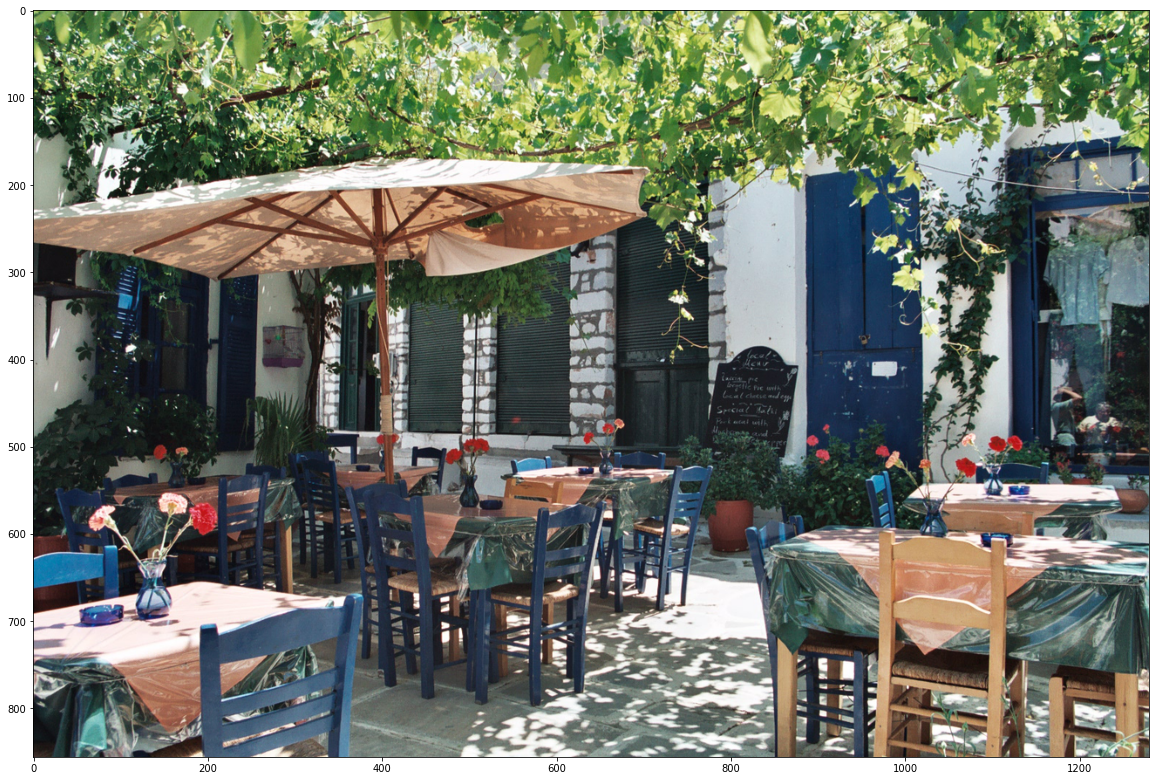

In [7]:
# By Heiko Gorski, Source: https://commons.wikimedia.org/wiki/File:Naxos_Taverna.jpg
image_url = "https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg"  #@param
#image_url = "https://www.exploregeorgia.org/sites/default/files/listing_images/profile/2822/piedmontpark.jpg"
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

Now its time to load our Faster R-CNN model and discuss it a bit before implementing it:

In [8]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

First of all, R-CNN stands for region based convolutional neural networks. Traditional object detection follows a 3 step pipeline: 
1) Region Proposal Generator - the point of this is step is propose candidate regions that might have objects in them.
2) Feature Extraction - this is usually a feature vector that is created to describe the image, and is hopefully invariant under scaling and/or translation transformations. 3) Classification - as you can probably imagine, the feature vector is used to assign each proposed region to one of the object classes.



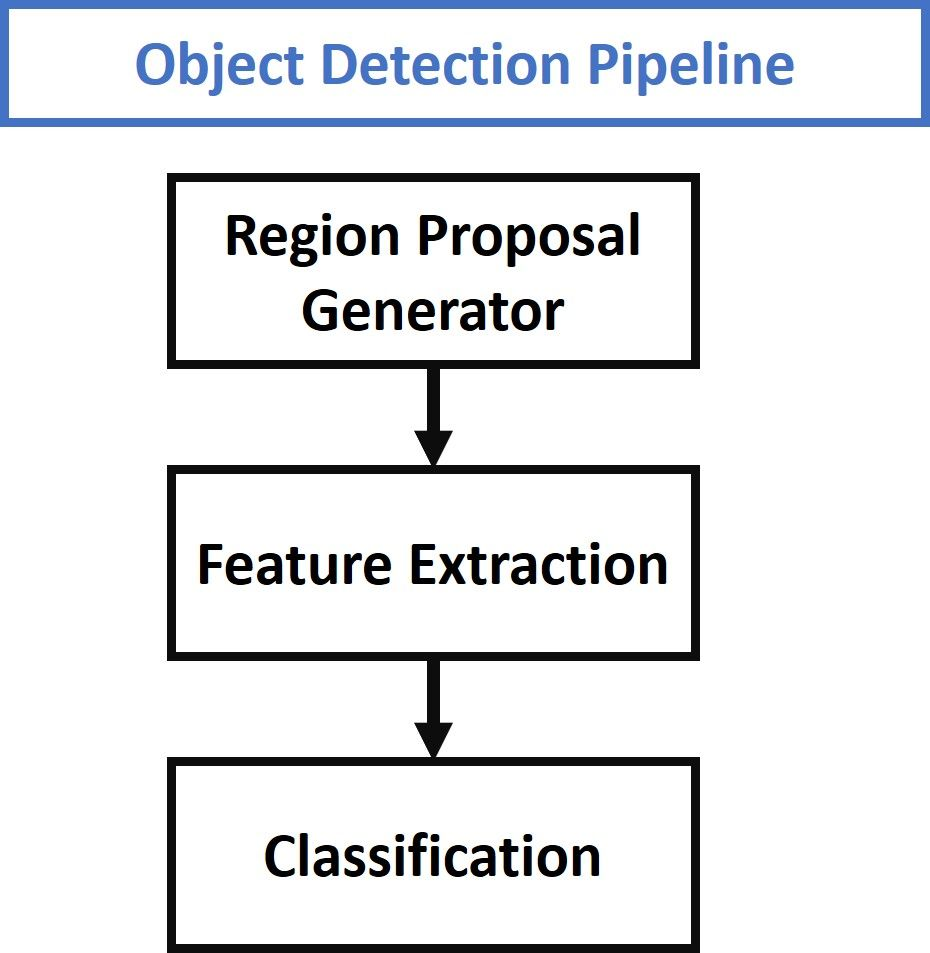

The point of the R-CNN model is mostly to extract the features using a convolutional neurel network. First, the model generates 2,000 region proposals using something called a Selective Search algorithm. Then the feature vector is extracted, after which a support vector machine is used for classification. There are a couple of downsides to the R-CNN model, one of the main ones being that the Selective Search algorithm takes a lot of time. Hence the need for something... fast.

Fast R-CNN actually came before Faster R-CNN, and it made some significant contributions:
1) ROI Pooling - a new layer that extracts equal-length feature vectors from all region proposals in the image. 
2) Single Stage - rather than going through the 3 stages discussed before and shown in the image above, Fast R-CNN is able to build a network that has one step.
3) Storage - Fast R-CNN doesn't cache the extracted features so it doesn't need as much disk storage as R-CNN.

Fast R-CNN also sees improvements in accuracy. It's general architecture is shown below:

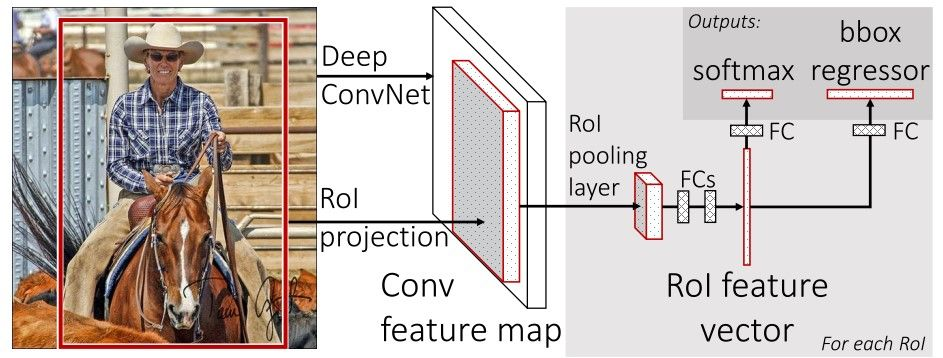

More information on the ROI Pooling layer can be found here: https://deepsense.ai/region-of-interest-pooling-explained


Finally, we get to Faster R-CNN, which is even faster than Fast R-CNN!!

Some of the main additions/changes are the following:

1) Region Proposal Network - a fully convolutional network that generates region proposals with various scales and aspect ratios. This takes advantage of the concept of attention, something we discussed a while back in class.

2) Anchor Boxes - a reference box of specific scale and aspect ratio. Each region is mapped ot a reference anchor box, which allows for detecting objects at different scales and aspect ratios. Think "pyramid of reference anchor boxes" as opposed to pyramids of images or filters.

3)The convolutional computations are shared across the region proposal network and the Fast R-CNN, which reduces the computational time.

The architecture can be seen below:

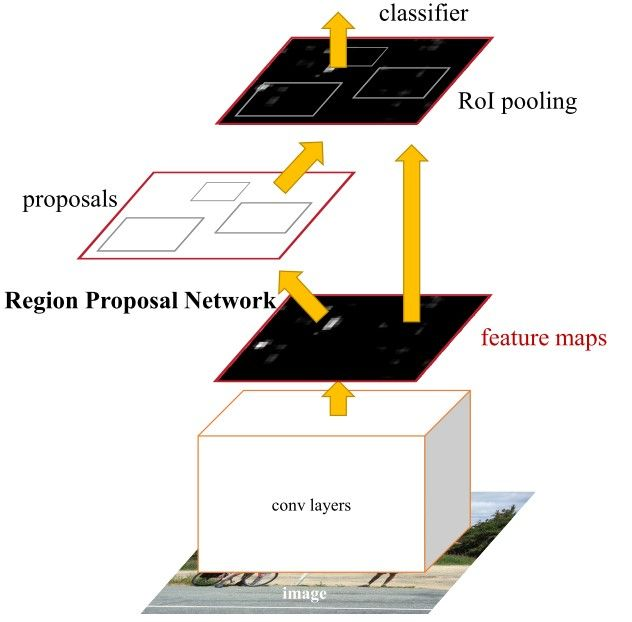

The above descriptions were very "big-picture". If you'd like to see a notebook that goes even more in depth, I encourage you to check out https://github.com/wingedrasengan927/pytorch-tutorials/blob/master/Object%20Detection/Faster%20R-CNN.ipynb


Going back to our implementation, we need to build a function that loads the image from its path, and a function that actually runs our Faster R-CNN model to detect objects in the image:

In [9]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [10]:
def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

Now we run our detector to see the results of the Faster R-CNN model:

Found 100 objects.
Inference time:  71.14757704734802


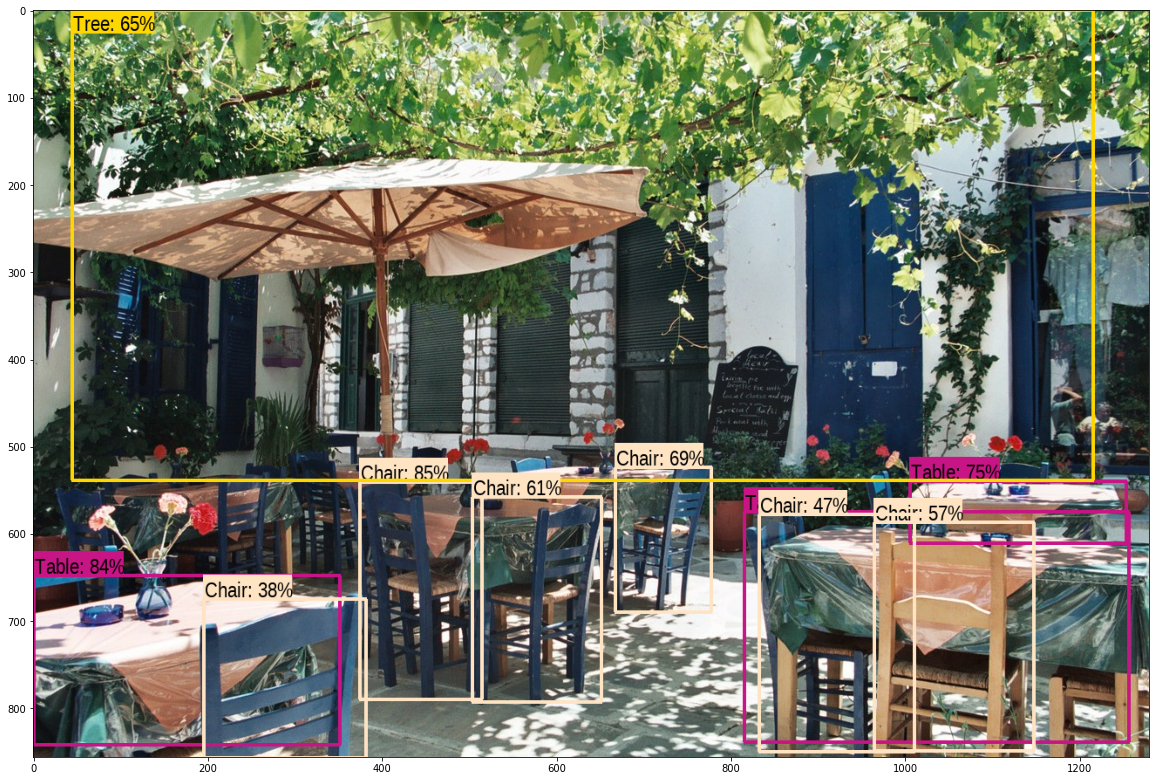

In [11]:
run_detector(detector, downloaded_image_path)

Pretty cool! Let's try this on a few more images now:

In [12]:
image_urls = [
  # Source: https://commons.wikimedia.org/wiki/File:The_Coleoptera_of_the_British_islands_(Plate_125)_(8592917784).jpg
  "https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg",
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg",
  # Source: https://commons.wikimedia.org/wiki/File:The_smaller_British_birds_(8053836633).jpg
  "https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg",
  ]

def detect_img(image_url):
  start_time = time.time()
  image_path = download_and_resize_image(image_url, 640, 480)
  run_detector(detector, image_path)
  end_time = time.time()
  print("Inference time:",end_time-start_time)

Image downloaded to /tmp/tmpgg7tffee.jpg.
Found 100 objects.
Inference time:  31.340972661972046
Inference time: 32.01829981803894


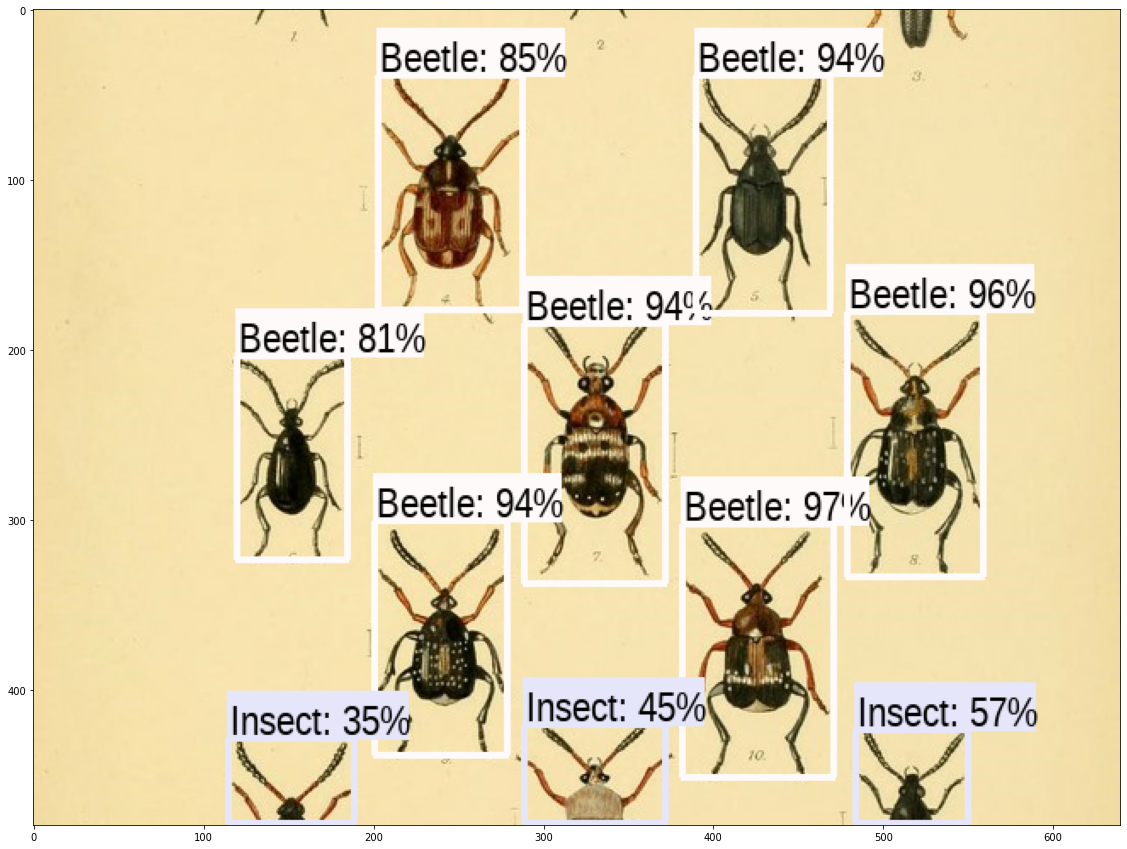

In [13]:
detect_img(image_urls[0])

Image downloaded to /tmp/tmpgd511ew6.jpg.
Found 100 objects.
Inference time:  30.470688104629517
Inference time: 31.294715404510498


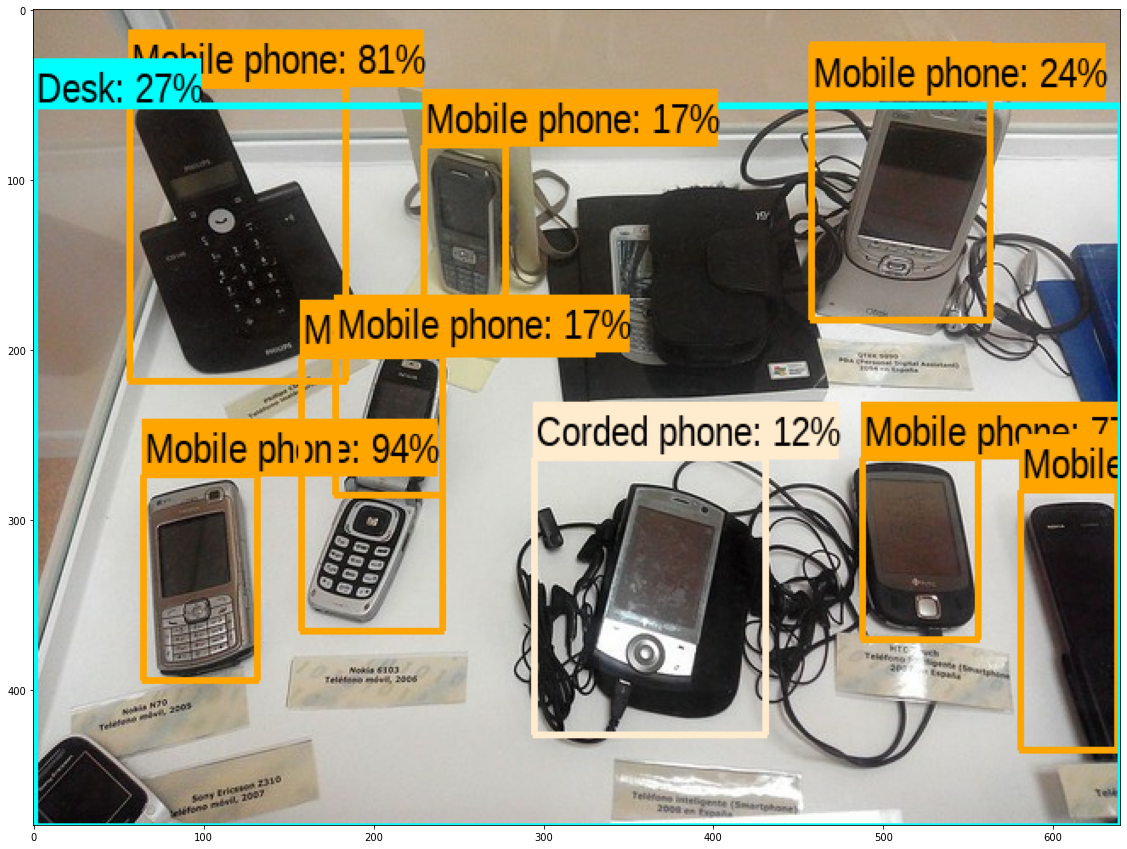

In [14]:
detect_img(image_urls[1])

Image downloaded to /tmp/tmp55w00xf4.jpg.
Found 100 objects.
Inference time:  30.69782066345215
Inference time: 31.733073472976685


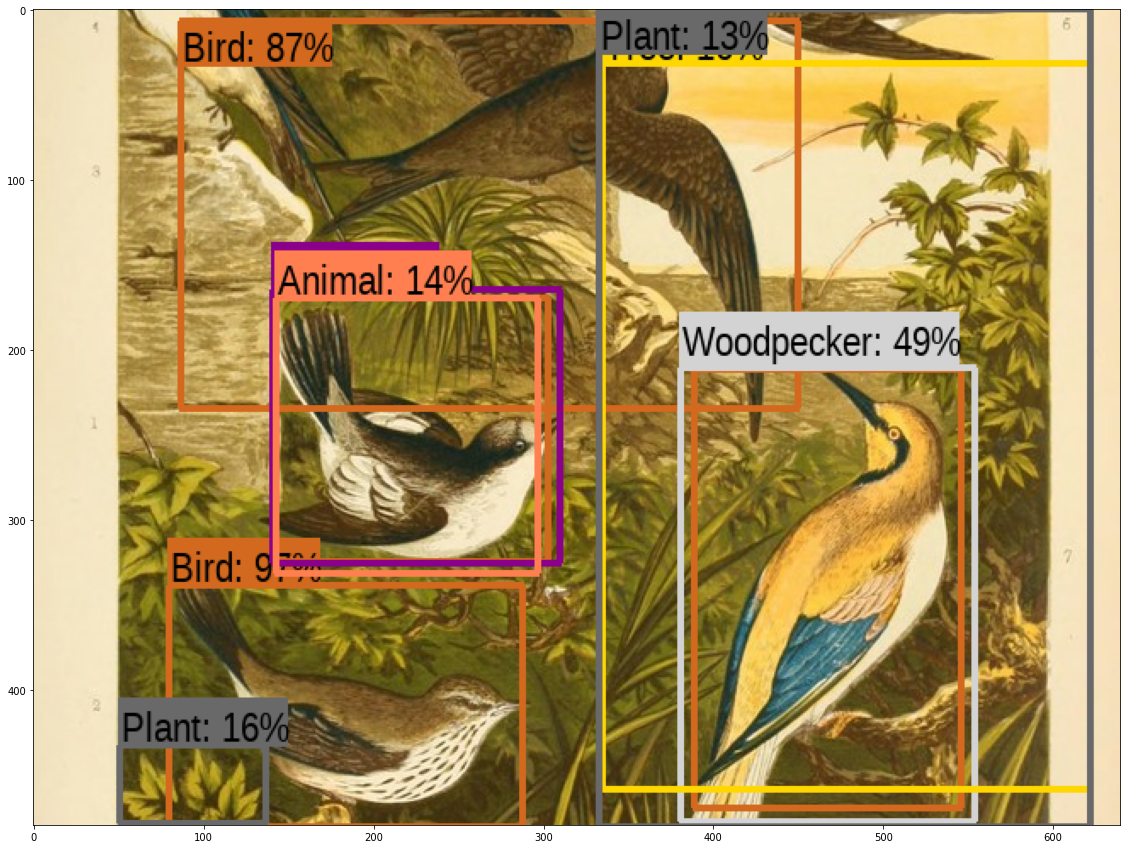

In [15]:
detect_img(image_urls[2])

# Conclusion
R-CNN, Fast R-CNN, and Faster R-CNN are all really cool region based methods for detecting objects in images. The goal of this notebook was to learn a little about these models and see how they can be implemented using Tensorflow. With more time, I would've loved to go more in depth talking about the Region Proposal Network and Anchor Boxes, since those are the novel parts of the Faster R-CNN model. I encourage anyone interested to check those out further. I also would've liked to use this model on my own images, but I was having trouble making it work for this notebook